In [1]:
!pip install optuna -q
!pip install --upgrade datasets -q
!pip install --upgrade triton -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive') # mounting drive where files are stored

Mounted at /content/drive


In [3]:
import sys
path = "/content/drive/MyDrive/AI_Cybersecurity/Project/"
sys.path.append(path)

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F # loading libraries
from sklearn.datasets import load_iris
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_from_disk
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from contextlib import nullcontext
from utils import BPE_Tokenizer, XGBoost, train_model, test_model, run_inference_and_collect_results, calculate_auc_roc, plot_confusion_matrix, test_model_adversarial, run_inference_and_collect_results_adversarial, multiples_of_two

In [6]:
tokenizer = BPE_Tokenizer(directory=path+'Tokenizer')
vocab = tokenizer.vocab
vocab_size = len(vocab) + 1
print("Vocab size is", vocab_size)

Vocab size is 10007


In [7]:
tokenized_dataset = load_from_disk(path+"Datasets/FinalDataset/")

In [8]:
train_dataset = tokenized_dataset['train']
val_dataset = tokenized_dataset['validation']
test_dataset = tokenized_dataset['test']

In [9]:
train_df = tokenized_dataset['train'].to_pandas()
val_df = tokenized_dataset['validation'].to_pandas()
test_df = tokenized_dataset['test'].to_pandas()

In [10]:
batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [11]:
device = 'cpu'
metadata_vector_length = 1024
num_metadata_features = len(train_dataset['metadata'][0])
max_context_size = 256
max_lr = 2e-4
max_depth=6               # Maximum tree depth for XGBoost
n_estimators=100

In [12]:
# Initialize the model for binary classification of class 0
model = XGBoost(max_context_size,              # Maximum length of input sequences
        num_metadata_features=num_metadata_features,  # Number of metadata features (optional)
    ).to(device)

# Test the model with the initial untrained state and compute training loss
for batch in train_loader:
    inputs = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    metadata = batch["metadata"].to(device)
    labels = batch["label"].to(device)
    model.fit(inputs, attention_mask, metadata, labels)
    logits, _ = model(inputs, attention_mask, metadata, labels)  # Forward pass through the model
    print(logits.shape)
    break

torch.cuda.empty_cache()

loss = test_model(model, train_loader, fp16=True, device=device)  # Compute the loss on the training dataset
print(f"Initial Training Loss {loss:.4f}")

torch.Size([188636, 2])
Initial Training Loss 0.4759


In [29]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 20)
    learning_rate =  trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    min_child_weight =  trial.suggest_float("min_child_weight", 1, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

    # Create the model
    model = XGBoost(
        context_size=max_context_size,
        num_metadata_features=num_metadata_features,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
    )

    # Test the model with the initial untrained state and compute training loss
    for batch in train_loader:
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        metadata = batch["metadata"].to(device)
        labels = batch["label"].to(device)
        model.fit(inputs, attention_mask, metadata, labels)

    # Evaluate on the validation set
    val_loss = test_model(model, val_loader, device, fp16=True)

    # Return the validation loss as the objective to minimize
    return val_loss

In [30]:
# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Run the optimization
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

[I 2024-12-06 15:53:36,339] A new study created in memory with name: no-name-38ded2fa-8c0d-475b-9995-b421a4d2503f
[I 2024-12-06 15:54:15,215] Trial 0 finished with value: 0.47670572996139526 and parameters: {'max_depth': 11, 'learning_rate': 0.018065702767756223, 'n_estimators': 305, 'min_child_weight': 6.129939407825834, 'subsample': 0.915206260463453, 'colsample_bytree': 0.9025342952773521, 'gamma': 2.2599574607109796, 'reg_alpha': 0.3751887582254021, 'reg_lambda': 5.72210601478713}. Best is trial 0 with value: 0.47670572996139526.
[I 2024-12-06 15:54:51,901] Trial 1 finished with value: 0.47601720690727234 and parameters: {'max_depth': 18, 'learning_rate': 0.09952337264604756, 'n_estimators': 277, 'min_child_weight': 8.24728968836228, 'subsample': 0.7827403420728571, 'colsample_bytree': 0.9979741240834819, 'gamma': 4.5267003811214535, 'reg_alpha': 9.567003638606694, 'reg_lambda': 7.867246885887313}. Best is trial 1 with value: 0.47601720690727234.
[I 2024-12-06 15:55:27,830] Trial 2

Best hyperparameters:
max_depth: 13
learning_rate: 0.27760551233315656
n_estimators: 483
min_child_weight: 1.033614310397153
subsample: 0.9290605659365785
colsample_bytree: 0.7774562047499791
gamma: 0.032848153883781595
reg_alpha: 2.219059425404553
reg_lambda: 5.620787499974691


In [13]:
max_depth = 13
learning_rate = 0.27760551233315656
n_estimators = 483
min_child_weight = 1.033614310397153
subsample = 0.9290605659365785
colsample_bytree = 0.7774562047499791
gamma = 0.032848153883781595
reg_alpha = 2.219059425404553
reg_lambda = 5.620787499974691

In [15]:
model = XGBoost(context_size=max_context_size, num_metadata_features=num_metadata_features, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda,)

# Test the model with the initial untrained state and compute training loss
for batch in train_loader:
    inputs = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    metadata = batch["metadata"].to(device)
    labels = batch["label"].to(device)
    model.fit(inputs, attention_mask, metadata, labels)

In [16]:
test_results = run_inference_and_collect_results(model, test_loader, device, fp16=True)
test_loss = test_model(model, test_loader, device, fp16=False)

accuracy = accuracy_score(test_results['Predicted Outputs'], test_results['True Labels']) * 100
precision = precision_score(test_results['True Labels'], test_results['Predicted Outputs'])
recall = recall_score(test_results['True Labels'], test_results['Predicted Outputs'])
f1 = f1_score(test_results['True Labels'], test_results['Predicted Outputs'])

print(f'Final Test Loss: {test_loss:.4f}')
print(f"Final Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Final Test Loss: 0.4759
Final Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


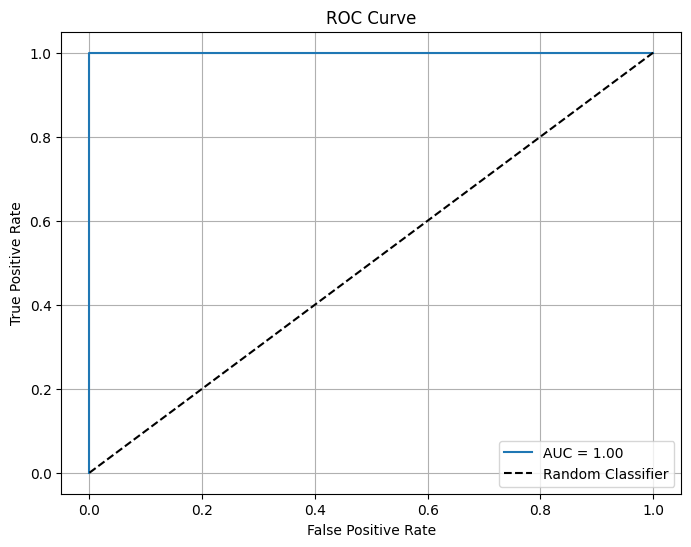

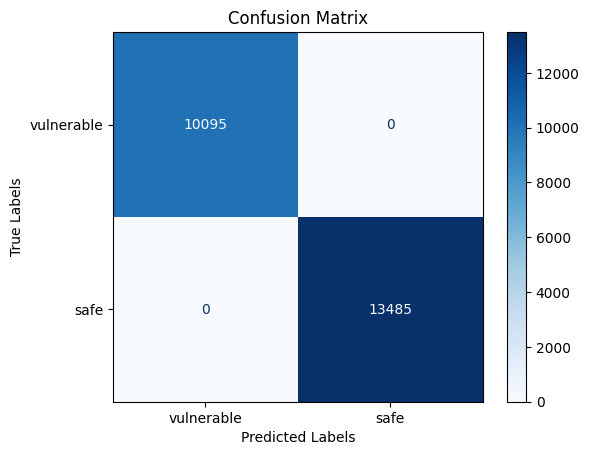

The Area Under Curve (AUC) is: 1.00


In [17]:
auc = calculate_auc_roc(model, test_loader, device)
plot_confusion_matrix(model, test_loader, device)
print(f'The Area Under Curve (AUC) is: {auc:.2f}')

In [18]:
adversarial_tokenized_dataset = load_from_disk(path+"Datasets/TransformedDataset/")

adversarial_train_dataset = adversarial_tokenized_dataset['train']
adversarial_val_dataset = adversarial_tokenized_dataset['validation']
adversarial_test_dataset = adversarial_tokenized_dataset['test']

batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
adversarial_train_loader = DataLoader(adversarial_train_dataset, batch_size=batch_size, shuffle=True)
adversarial_val_loader = DataLoader(adversarial_val_dataset, batch_size=batch_size, shuffle=True)
adversarial_test_loader = DataLoader(adversarial_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
adversarial_losses = test_model_adversarial(model, adversarial_test_loader, device, fp16=True)
adversarial_results = run_inference_and_collect_results_adversarial(model, adversarial_test_loader, device, fp16=True)

In [20]:
print("Adversarial Losses:")
print(f"Original Loss: {adversarial_losses['original_loss']:.4f}")
print(f"Similar Characters Loss: {adversarial_losses['similar_loss']:.4f}")
print(f"Case Symbols Loss: {adversarial_losses['case_symbols_loss']:.4f}")
print(f"Unicode Replacement Loss: {adversarial_losses['unicode_loss']:.4f}\n")

# Evaluate metrics for each type
for key in adversarial_results:
    predictions = adversarial_results[key]["predictions"]
    labels = adversarial_results[key]["labels"]

    accuracy = accuracy_score(labels, predictions) * 100
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    print(f"Results for {key.capitalize()} Inputs:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print("\n")

Adversarial Losses:
Original Loss: 0.4759
Similar Characters Loss: 0.5013
Case Symbols Loss: 0.4762
Unicode Replacement Loss: 0.4918

Results for Original Inputs:
  Accuracy: 100.00%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


Results for Similar Inputs:
  Accuracy: 92.07%
  Precision: 1.00
  Recall: 0.86
  F1 Score: 0.93


Results for Case symbols Inputs:
  Accuracy: 99.98%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


Results for Unicode Inputs:
  Accuracy: 94.23%
  Precision: 1.00
  Recall: 0.90
  F1 Score: 0.95


